## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from collections import OrderedDict
import pickle
import utils
import os.path
%matplotlib inline

# load test images

In [3]:
paths = glob.glob('test_images/*')
images = [cv2.imread(p) for p in paths]
if None in images:
    print('images not read: ', images.count(None))

/home/chiro/workspace/self_driving_car/pyenv/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


# Definitions

In [621]:
# load precomputed camera calibration
mtx, dist = utils.load_calibration_params('calibration_params.p')

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#              REGION OF INTEREST
# # # # # # # # # # # # # # # # # # # # # # # # # # # # #

crop_bot = 0.0694  # percentile to crop on bottom
crop_top = 0.625  # percentile to crop on top

bot_left = 0.15625  # percentile to crop on botom left
top_left = 0.45  # percentile to crop on top left

bot_right = 0.0625  # percentile to crop on bottom right
top_right = 0.45  # percentile to crop on top right

# # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#              WARPING
# # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# source coordinates of lane trapezoid in straight road
bot, top = 720-50, 450  # bottom and top height
tl = 595  # top left a
bl = 290  # bot left x
tr = 690  # top right x
br = 1030  # bot right x

src_coords = np.float32([
            (bl, bot),  # bottom left vertex
            (br, bot),  # bottom right vertex
            (tr, top),  # top right vertex
            (tl, top)  # top left vertex
           ])

margin = 300
h, w = 720, 1280
dst_coords = np.array([(0+margin, h),
                (w-margin, h),
                (w-margin, 0),
                (0+margin, 0)], dtype=np.float32)
warp_M = cv2.getPerspectiveTransform(src_coords, dst_coords)
unwarp_M = cv2.getPerspectiveTransform(dst_coords, src_coords)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#              THRESHOLDING
# # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# parameters for Sobel direction thresholding
sobel_dir = dict()
sobel_dir['tbot'] = 0.7
sobel_dir['ttop'] = np.pi/2
sobel_dir['tinc'] = np.deg2rad(3)
sobel_dir['sobel_kernel'] = 3
sobel_dir['sobel_kernel_inc'] = 2

# parameters for HSL saturation thresholding
saturation = dict()
saturation['tbot'] = 0
saturation['ttop'] = 255
saturation['tinc'] = 5

# parameters for Sobel magnitude thresholding
mag_bin = {'tinc': 5,
           'tbot': 100,
           'ttop': 255,
           'sobel_kernel': 3,
           'sobel_kernel_inc': 2
          }

# parameters for red threshold
red_threshold = {'tinc': 5,
                 'tbot':205,
                 'ttop': 255}

## Load thresholding parameters from file

In [622]:
# load thresholding configuration values
with open('threshold_configs.p', 'rb') as f:
    c = pickle.load(f)
    
sobel_dir = c['sobel_dir']
saturation = c['hsl saturation']
mag_bin = c['mag_bin']
red_threshold = c['red']

## Save thresholding parameters to file

In [432]:
# save thresholding configuration values
c = {
    'sobel_dir': sobel_dir,
    'hsl saturation': saturation,
    'mag_bin': mag_bin,
    'red': red_threshold
}

with open('threshold_configs.p', 'wb') as f:
    pickle.dump(c, f)

# Functions

In [619]:
def load_funcs():
    with open('funcs.py', 'r') as f:
        exec(f.read())
    with open('pipeline.py', 'r') as f:
        exec(f.read())

In [616]:
# %run funcs.py
with open('funcs.py', 'r') as f:
    code = f.readlines()
    for i, l in enumerate(code):
        print(i, l, end='')
    exec(''.join(code))

0 import pickle
1 import numpy as np
2 import cv2
3 
4 def write_on_image(img, txt=[]):
5     'write strings in txt in corresponding lines in lines'
6     img = img.copy()
7     x, y = 0, 35
8     for l, t in enumerate(txt):
9         cv2.putText(img, t, (0, y * (l + 1)), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
10     return img
11 
12 def region_of_interest(img, vertices):
13     """
14     Applies an image mask.
15 
16     Only keeps the region of the image defined by the polygon
17     formed from `vertices`. The rest of the image is set to black.
18 
19     Taken from project 1.
20     """
21     #defining a blank mask to start with
22     mask = np.zeros_like(img)
23 
24     #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
25     if len(img.shape) > 2:
26         channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
27         ignore_mask_color = (255,) * channel_count
28     else:
29         ignore_mask_color = 255
30 
31     

In [617]:
# %run pipeline.py
with open('pipeline.py', 'r') as f:
    code = f.readlines()
    for i, l in enumerate(code):
        print(i, l, end='')
    exec(''.join(code))

def apply_pipeline(img):
    ret = pipeline(img)
    return ret['final']

0 import cv2
1 import numpy as np
2 from collections import OrderedDict
3 
4 def pipeline(img):
5     img = img.copy()
6     h, w = img.shape[:2]
7     txt = []
8     ret_frames = OrderedDict()
9 
10 
11     ret_frames['input'] = img
12 
13     ## undistort input image
14     undistorted = cv2.undistort(img, mtx, dist, None, mtx)
15     ret_frames['undistorted'] = undistorted
16 
17     ## warp undistorted image
18     undistorted_warped = warp(undistorted)
19     ret_frames['undistorted_warped'] = undistorted_warped
20 
21     ## apply Sobel direction thresholding to warped undistorted
22     sobel_dir_threshold = dir_threshold(undistorted_warped,
23                                         sobel_kernel=sobel_dir['sobel_kernel'],
24                                         thresh=(sobel_dir['tbot'], sobel_dir['ttop']))
25     ret_frames['sobel_dir'] = sobel_dir_threshold
26 
27     ## apply HSL saturation thresholding to warped undistorted
28     sat_bin = hls_select(undistorted_warped,

# Figuring out the source and destination warp coords


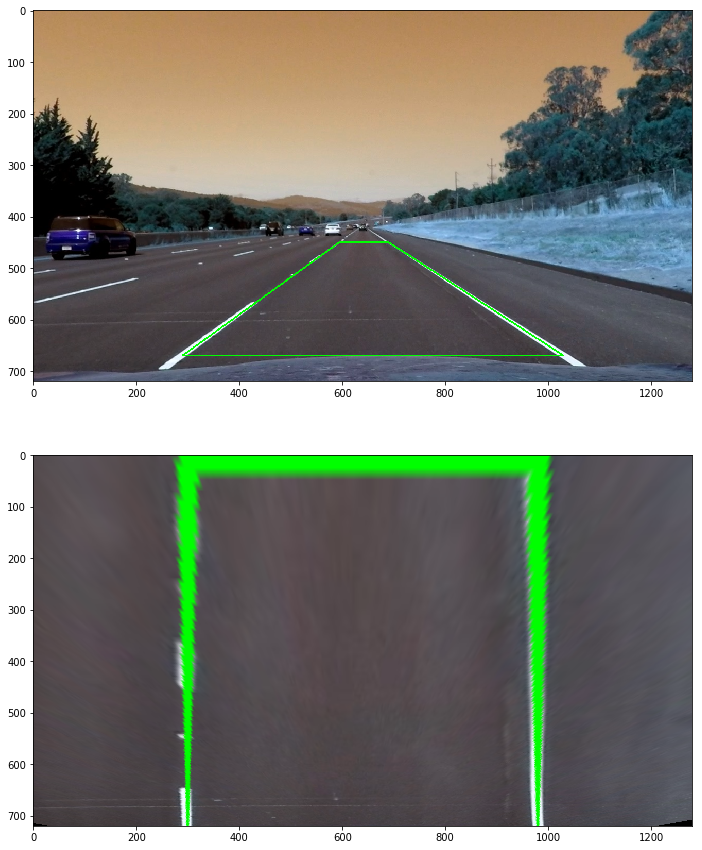

In [618]:
# Figuring out the source and destination warp coords

# coordinates of lane trapezoid in straight road
bot, top = 720-50, 450  # bottom and top height
tl = 595  # top left a
bl = 290  # bot left x
tr = 690  # top right x
br = 1030  # bot right x

fig, subplots = plt.subplots(2, 1, figsize=(15,15))
ax1, ax2 = subplots
ret = pipeline(images[7])
img = ret['undistorted'].copy()

pts = [(tl, top),
       (tr, top),
       (br, bot),
       (bl, bot)]

cv2.polylines(img, np.int32([pts]), True, (0, 255, 0), 2)
ax1.imshow(img)
ax2.imshow(warp(img))

# Applying the pipeline

In [313]:
vid_files = glob.glob('video_imgs/project_video/*')
numbered_vid_fn = [(int(fn.split('/')[-1].rstrip('.jpg')), fn) for fn in vid_files]
numbered_vid_fn.sort()

In [385]:
cv2.imshow('frame', warped)
cv2.waitKey()
cv2.destroyAllWindows()

In [532]:
bad_idx = 1143
idx, img_fn = numbered_vid_fn[bad_idx]
img = cv2.imread(img_fn)

In [533]:
ret = pipeline(img)

In [537]:
img = img.copy()
txt = []
ret_frames = OrderedDict()


ret_frames['input'] = img

## undistort input image
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
ret_frames['undistorted'] = undistorted

## warp undistorted image
undistorted_warped = warp(undistorted)
ret_frames['undistorted_warped'] = undistorted_warped

## apply Sobel direction thresholding to warped undistorted
sobel_dir_threshold = dir_threshold(undistorted_warped,
                                    sobel_kernel=sobel_dir['sobel_kernel'],
                                    thresh=(sobel_dir['tbot'], sobel_dir['ttop']))
ret_frames['sobel_dir'] = sobel_dir_threshold

## apply HSL saturation thresholding to warped undistorted
sat_bin = hls_select(undistorted_warped,
                     thresh=(saturation['tbot'], saturation['ttop']))
ret_frames['sat_bin'] = sat_bin

## apply red thresholding to warped undistorted
red_bin = bgr_threshold(undistorted_warped,
                        thresh=(red_threshold['tbot'], red_threshold['ttop']),
                        channel=2)
ret_frames['red_bin'] = red_bin

red_sat_bin = np.empty_like(red_bin)
red_sat_bin[(red_bin > 0) | (sat_bin > 0)] = 255
ret_frames['poly input'] = red_sat_bin

## sliding window, fit polynomial, radius, center offset, polygon mask
img = ret_frames['poly input']
# get left and right lane points for polynomial fit
lx, ly, rx, ry = get_points_for_fit(img)  # sliding window

points_drawn = np.zeros((h,w,3), dtype=np.uint8)
points_drawn[ly,lx,0] = 255
points_drawn[ry,rx,1] = 255

lp, rp = poly_from_points(lx, ly, rx, ry)  # left and right polynomials in pixel space
lm, rm = fit_poly(img, meters=False)  # left and right polynomials in meter space

# compute real world radius of curvature
l_radius, r_radius = compute_curvature(y=img.shape[0]-1,
                                       left_fit=lm, right_fit=rm,
                                       meters=False)
# compute center offset
center_offset = compute_center_offset(lp, rp, meters=True)

# create a mask with a filled polygon drawn from the polynomials
h, w = img.shape[:2]
polygon_mask = np.zeros((h, w, 3), dtype=np.uint8)
#polygon_mask[img>0] = 255
l_fn, r_fn = get_poly_funcs(lp, rp)
polygon_mask = draw_poly_lines(polygon_mask, l_fn, r_fn, fill=True)

txt.append('radii left={:.1f} right={:.1f}'.format(l_radius, r_radius))
txt.append('offset {:.2f}m'.format(center_offset))

ret_frames['polygon_mask'] = polygon_mask

## unwarp polygon mask
unwarped_polygon_mask = unwarp(polygon_mask)
ret_frames['unwarped_polygon_mask'] = unwarped_polygon_mask

## overlay polygon mask with undistorted image
overlay = undistorted.copy()
overlay[unwarped_polygon_mask > 0] = 255

ret_frames['overlay'] = overlay

final_image = overlay
out_img = write_on_image(final_image, txt)
ret_frames['final'] = out_img

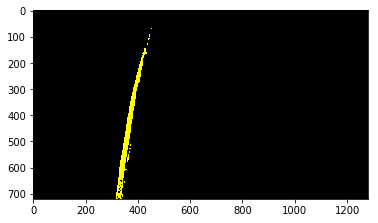

In [538]:
plt.imshow(points_drawn)

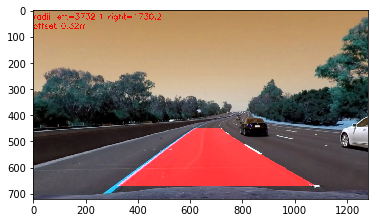

In [552]:
bad_idx = 1143
idx, img_fn = numbered_vid_fn[bad_idx]
img = cv2.imread(img_fn)
ret = pipeline(img)

undistorted = cv2.undistort(img, mtx, dist, None, mtx)
warped = warp(undistorted)
sat_bin = hls_select(warped,
                     thresh=(saturation['tbot'], saturation['ttop']))
plt.imshow(ret['final'])

In [484]:
saturation

{'tbot': 175, 'tinc': 5, 'ttop': 250}

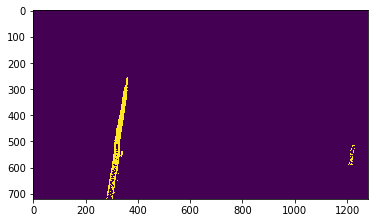

In [486]:
img = hls_select(ret['undistorted_warped'], thresh=(saturation['tbot'], saturation['ttop']))
plt.imshow(img)

In [534]:
_, im_fn = numbered_vid_fn[idx]
ret = pipeline(cv2.imread(im_fn))

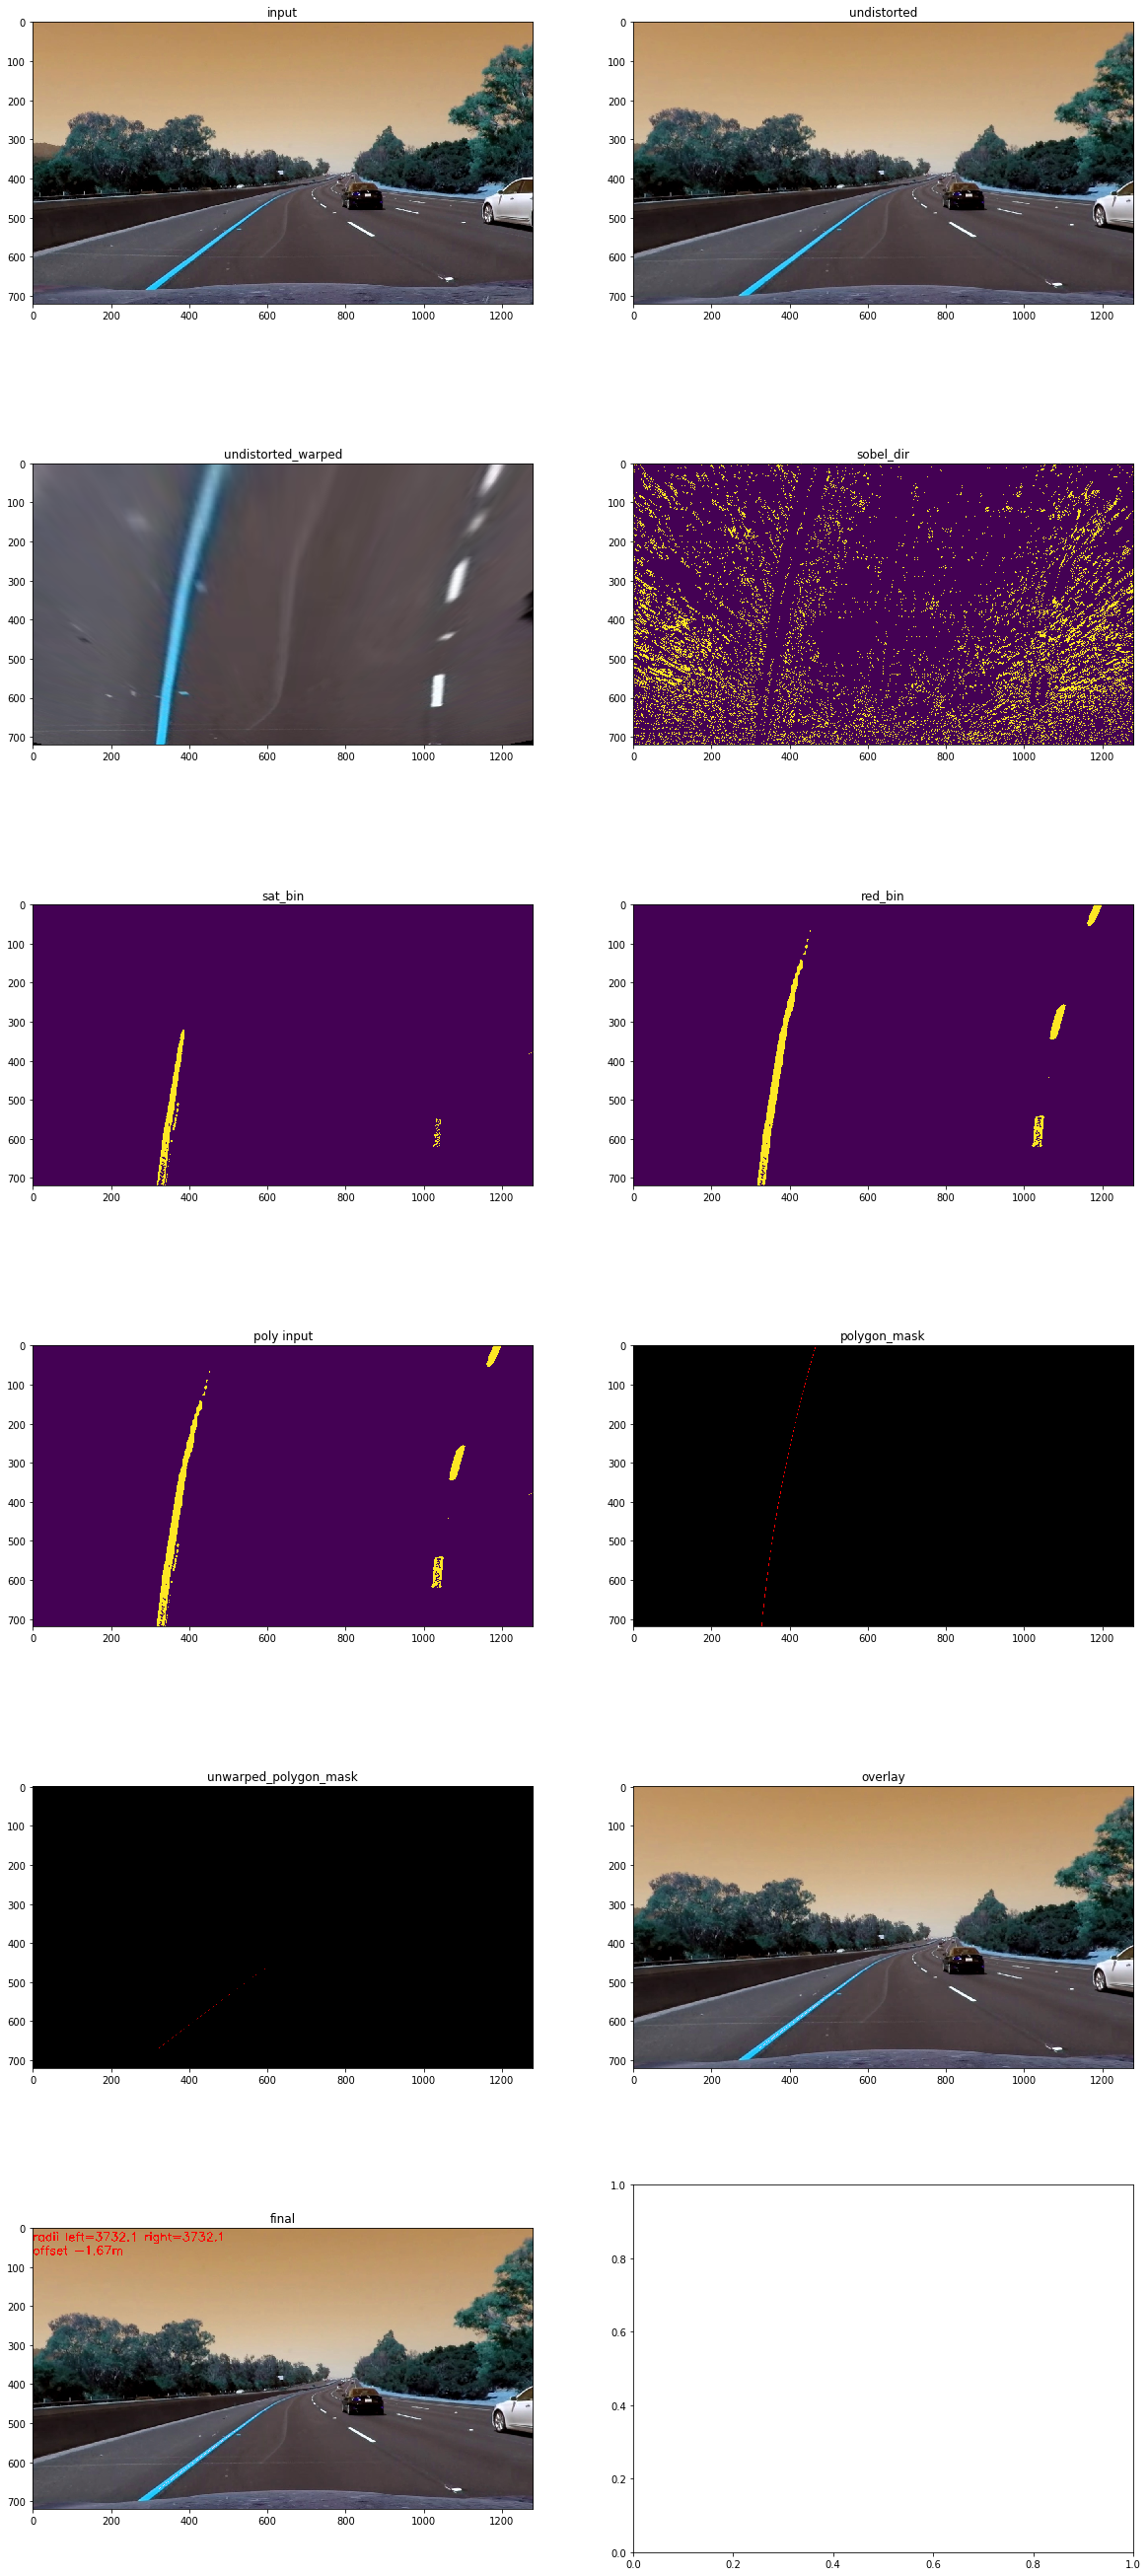

In [536]:
n = len(ret)
rows = int(n / 2) + 1
cols = 2
fig, subplots = plt.subplots(rows, cols, figsize=(20, 8*rows))
subplots = subplots.reshape((rows*cols))
i = 0
for desc, im in ret.items():
    subplots[i].imshow(im)
    subplots[i].set_title(desc)
    i += 1

In [558]:
import multiprocessing as mp
import tempfile

In [626]:
viz_folder = tempfile.mkdtemp()
print(viz_folder)
with open('viz_metadata.p', 'wb') as f:
    meta = {'folder': viz_folder, 'length': len(numbered_vid_f)}
    pickle.dump(meta ,f)
for idx, fn in numbered_vid_fn:
    img = cv2.imread(fn)
    if img is None:
        print('image not read with index ', i)
        continue
    ret = pipeline(img)
    with open(os.path.join(viz_folder, '{}.p'.format(idx)), 'wb') as f:
        pickle.dump(ret, f)

/tmp/tmpibf4msh_


KeyboardInterrupt: 

In [593]:
timeout = 42
inc = 1
i = 0
while True:
    idx, fn = numbered_vid_fn[i]
    img = cv2.imread(fn)
    if img is None:
        print('image not read with index ', i)
        continue
    ret = pipeline(img)
    show_img = write_on_image(ret['final'], txt=['','','image {}/{}'.format(idx, len(numbered_vid_fn))])
    cv2.imshow('frame', show_img)
    key = cv2.waitKey(timeout)
    if key == ord('q'):
        break
    if key == ord('w'):
        # show all frames from pipeline
        for desc, im in ret.items():
            tmp = write_on_image(im, txt=[desc])
            cv2.imshow('frame', tmp)
            cv2.waitKey()
    elif key == ord(' '):
        if timeout == 0:
            timeout = 42
        else:
            timeout = 0
    elif key == ord('m'):
        timeout = 0
        i += inc
        i = min(i, len(numbered_vid_fn) - 1)
    elif key == ord('n'):
        timeout = 0
        i -= inc
        i = max(0, i)
    else:
        i += inc
        i = min(i, len(numbered_vid_fn) - 1)
cv2.destroyAllWindows()

In [478]:
cv2.destroyAllWindows()

In [626]:
histogram = np.sum(binary_warped, axis=0)

out_img = np.dstack((binary_warped, binary_warped, binary_warped))
midpoint = int(h / 2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

nwindows = 9
window_h = int(h / nwindows)
nonzeroy, nonzerox = binary_warped.nonzero()

leftx_current = leftx_base  # will be updated
rightx_current = rightx_base  # will be updated

margin = 100  # width of window for each side
minpix = 50  # minimum of pixels found on window to recenter

left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    # degine top and bottom window heights
    win_y_low = h - (window + 1) * window_h
    win_y_high = h - window * window_h
    # degine left and right boundaries for left lane window
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    # degine left and right boundaries for right lane window
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
    cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
    
    # identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # if minimum pixels in window, recenter window around new mean
    if len(good_left_inds) >= minpix:
        leftx_current = int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) >= minpix:
        rightx_current = int(np.mean(nonzerox[good_right_inds]))

# concatenate the arrays of indices of all windows
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
    
# extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# fit second layer polynomial
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

left_fn = lambda x: left_fit[0] * x**2 + left_fit[1] * x + left_fit[2]
right_fn = lambda x: right_fit[0] * x**2 + right_fit[1] * x + right_fit[2]

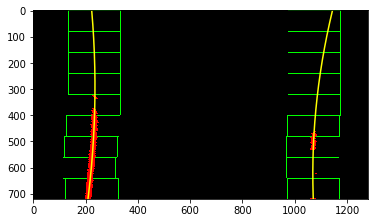

In [627]:
# visualize polynomials
ploty = np.linspace(0, h-1, h)
left_fitx = left_fn(ploty)
right_fitx = right_fn(ploty)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

# experiment with pipeline interactively

In [270]:
# adjust saturation threshold interactively
config = saturation
idx = 0
exit = False
key = ord('n')
txt = []

while not exit:
    if key == ord('q'):
        exit = True
        break

    elif key == ord('z'):
        img = warp(img)
        
        out_img = write_on_image(img, txt)
        cv2.imshow('frame', img)
        
    elif key == ord('x'):
        print('unwarping...')
        img = unwarp(img)
        
        out_img = write_on_image(img, txt)
        cv2.imshow('frame', out_img)
        
    elif key == ord('s'):
        img = hls_select(img, thresh=(saturation['tbot'], saturation['ttop'])) * 255
        txt.append('sat {} - {}'.format(config['tbot'], config['ttop']))
        
        print(img.shape)
    
        out_img = write_on_image(img, txt)
        cv2.imshow('frame', out_img)

    elif key == ord('o'):
        print('overlapping...')
        original = ret['undistorted']
        original[img > 0] = img[img > 0]
        img = original
        
        out_img = write_on_image(img, txt)
        cv2.imshow('frame', out_img)

    elif key == ord('c'):  # fit polynomial
        l, r = fit_poly(img)  # compute pixel polynomial
        # compute real world radius of curvature
        lm, rm = fit_poly(img, meters=True)
        l_radius, r_radius = compute_curvature(img.shape[0]-1, lm, rm, False)
        
        # compute center offset
        center_offset = compute_center_offset(l, r, meters=True)
        
        h, w = img.shape[:2]
        out_img = np.zeros((h, w, 3), dtype=np.uint8)
        out_img[img != 0] = 255
        lfn, rfn = get_poly_funcs(l, r)
        out_img = draw_poly_lines(out_img, lfn, rfn)
        img = out_img
        
        txt.append('radii left={:.1f} right={:.1f}'.format(l_radius, r_radius))
        txt.append('offset {:.2f}m'.format(center_offset))
        
        out_img = write_on_image(img, txt)
        cv2.imshow('frame', out_img)

    elif key == ord('n'):
        idx = max(0, idx - 1)

        ret = pipeline(images[idx])
        img = ret['undistorted']
        txt = ['image {}'.format(idx)]
        undo = []

        cv2.imshow('frame', img)

    elif key == ord('m'):
        idx = min(len(images) - 1, idx + 1)

        ret = pipeline(images[idx])
        img = ret['undistorted']
        txt = ['image {}'.format(idx)]
        undo = []
        
        cv2.imshow('frame', img)

    elif key == ord('<'):
        print('undoing...')
        if len(undo) > 1:
            img, txt = undo.pop()
            img, txt = undo.pop()
            cv2.imshow('frame', img)

    print('waiting for key...')
    undo.append((img.copy(), txt.copy()))
    key = cv2.waitKey()
        
cv2.destroyAllWindows()

waiting for key...
waiting for key...
(720, 1280)
waiting for key...
waiting for key...
unwarping...
waiting for key...
overlapping...
waiting for key...


# vizualize inside sliding windows

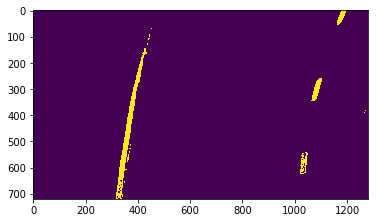

In [540]:
plt.imshow(ret['poly input'])

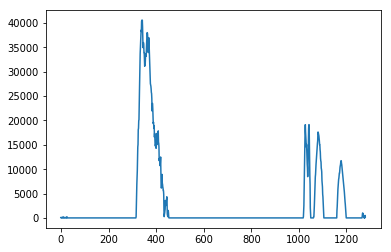

In [542]:
binary_warped = ret['poly input']
h, w = binary_warped.shape
histogram = np.sum(binary_warped, axis=0)

plt.plot(histogram)

In [546]:
binary_warped = ret['poly input']
nwindows=9

h, w = binary_warped.shape
histogram = np.sum(binary_warped, axis=0)

out_img = np.dstack((binary_warped, binary_warped, binary_warped))
midpoint = int(h / 2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

window_h = int(h / nwindows)
nonzeroy, nonzerox = binary_warped.nonzero()

leftx_current = leftx_base  # will be updated
rightx_current = rightx_base  # will be updated

margin = 100  # width of window for each side
minpix = 50  # minimum of pixels found on window to recenter

left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    # degine top and bottom window heights
    win_y_low = h - (window + 1) * window_h
    win_y_high = h - window * window_h
    # degine left and right boundaries for left lane window
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    # degine left and right boundaries for right lane window
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
    cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

    # identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # if minimum pixels in window, recenter window around new mean
    if len(good_left_inds) >= minpix:
        leftx_current = int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) >= minpix:
        rightx_current = int(np.mean(nonzerox[good_right_inds]))

# concatenate the arrays of indices of all windows
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

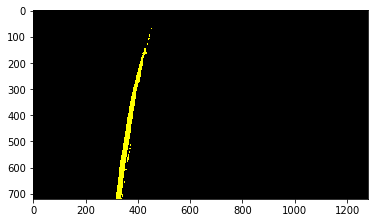

In [547]:
x = np.zeros((h,w,3), dtype=np.uint8)
x[lefty,leftx,0] = 255
x[righty,rightx,1]=255
plt.imshow(x)

# adjust Sobel direction threshold interactively

In [358]:
# adjust Sobel direction threshold interactively
config = sobel_dir
idx = 0
exit = False
while not exit:
    ret = pipeline(images[idx])
    hsl_bin = dir_threshold(ret['undistorted'], sobel_kernel=config['sobel_kernel'],
                            thresh=(config['tbot'], config['ttop']))
    hsl_bin = apply_roi(hsl_bin * 255)
    imtxt = write_on_image(hsl_bin, ['image {}'.format(idx),
                                         'sobel direction threshold',
                                         'kernel size={}'.format(config['sobel_kernel']),
                                         '{:.1f} - {:.1f}'.format(np.rad2deg(config['tbot']),
                                                                  np.rad2deg(config['ttop']))]
                          )
    cv2.imshow('frame', imtxt)
    key = cv2.waitKey()
    if key == ord('q'):
        exit = True
        break
    elif key == ord('u'):
        config['sobel_kernel'] += config['sobel_kernel_inc']
    elif key == ord('j'):
        config['sobel_kernel'] -= config['sobel_kernel_inc']
    elif key == ord('i'):
        config['tbot'] += config['tinc']
    elif key == ord('k'):
        config['tbot'] -=  config['tinc']
    elif key == ord('o'):
        config['ttop'] +=  config['tinc']
    elif key == ord('l'):
        config['ttop'] -=  config['tinc']
    elif key == ord('n'):
        idx = max(0, idx - 1)
    elif key == ord('m'):
        idx = min(len(images) - 1, idx + 1)
    elif key == ord('w'):
        cv2.imshow('frame', ret['undistorted'])
        cv2.waitKey()
        
cv2.destroyAllWindows()

# adjust magnitude threshold interactively

In [514]:
# adjust magnitude threshold interactively
config = mag_bin
idx = 0
exit = False
while not exit:
    ret = pipeline(images[idx])
    hsl_bin = mag_thresh(ret['undistorted'], sobel_kernel=config['sobel_kernel'],
                            thresh=(config['tbot'], config['ttop']))
    hsl_bin = apply_roi(hsl_bin * 255)
    imtxt = write_on_image(hsl_bin, ['image {}'.format(idx),
                                         'magnitude threshold',
                                         'kernel size={}'.format(config['sobel_kernel']),
                                         '{:.1f} - {:.1f}'.format(config['tbot'], config['ttop'])]
                          )
    cv2.imshow('frame', imtxt)
    key = cv2.waitKey()
    if key == ord('q'):
        exit = True
        break
    elif key == ord('u'):
        config['sobel_kernel'] += config['sobel_kernel_inc']
    elif key == ord('j'):
        config['sobel_kernel'] -= config['sobel_kernel_inc']
    elif key == ord('i'):
        config['tbot'] += config['tinc']
    elif key == ord('k'):
        config['tbot'] -=  config['tinc']
    elif key == ord('o'):
        config['ttop'] +=  config['tinc']
    elif key == ord('l'):
        config['ttop'] -=  config['tinc']
    elif key == ord('n'):
        idx = max(0, idx - 1)
    elif key == ord('m'):
        idx = min(len(images) - 1, idx + 1)
    elif key == ord('w'):
        cv2.imshow('frame', ret['undistorted'])
        cv2.waitKey()
        
cv2.destroyAllWindows()

# adjust saturation threshold interactively

In [420]:
# adjust saturation threshold interactively
config = saturation
idx = 0
exit = False
img = warped
while not exit:
#     ret = pipeline(images[idx])
#     img = ret['undistorted']

#     img = warp(img)    
    changed = hls_select(img, thresh=(config['tbot'], config['ttop']))
    
    h, w = img.shape[:2]
    out_img = np.zeros((h, w, 3), dtype=np.uint8)
    out_img = img.copy()
    out_img[changed != 0] = 255
    out_img = write_on_image(out_img, ['image {}'.format(idx),
                                       'saturation threshold',
                                       '{} - {}'.format(config['tbot'], config['ttop'])]
                          )
    cv2.imshow('frame', out_img)
    key = cv2.waitKey()
    if key == ord('q'):
        exit = True
        break
    elif key == ord('i'):
        config['tbot'] += config['tinc']
    elif key == ord('k'):
        config['tbot'] -=  config['tinc']
    elif key == ord('o'):
        config['ttop'] +=  config['tinc']
    elif key == ord('l'):
        config['ttop'] -=  config['tinc']
    elif key == ord('n'):
        idx = max(0, idx - 1)
    elif key == ord('m'):
        idx = min(len(images) - 1, idx + 1)
    elif key == ord('w'):
        cv2.imshow('frame', img)
        cv2.waitKey()
        
cv2.destroyAllWindows()

In [494]:
cv2.destroyAllWindows()

# adjust red threshold interactively

In [429]:
# adjust saturation threshold interactively
config = red_threshold
idx = 0
exit = False
img = warped
while not exit:
#     ret = pipeline(images[idx])
#     img = ret['undistorted']

#     img = warp(img)    
    changed = brg_threshold(img, thresh=(config['tbot'], config['ttop']), channel=2)
    
    h, w = img.shape[:2]
    out_img = np.zeros((h, w, 3), dtype=np.uint8)
    out_img = img.copy()
    out_img[changed != 0] = 255
    out_img = write_on_image(out_img, ['image {}'.format(idx),
                                       'red threshold',
                                       '{} - {}'.format(config['tbot'], config['ttop'])]
                          )
    cv2.imshow('frame', out_img)
    key = cv2.waitKey()
    if key == ord('q'):
        exit = True
        break
    elif key == ord('i'):
        config['tbot'] += config['tinc']
    elif key == ord('k'):
        config['tbot'] -=  config['tinc']
    elif key == ord('o'):
        config['ttop'] +=  config['tinc']
    elif key == ord('l'):
        config['ttop'] -=  config['tinc']
    elif key == ord('n'):
        idx = max(0, idx - 1)
    elif key == ord('m'):
        idx = min(len(images) - 1, idx + 1)
    elif key == ord('w'):
        cv2.imshow('frame', img)
        cv2.waitKey()
        
cv2.destroyAllWindows()

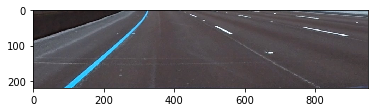

In [245]:
img = ret['input'].copy()
img = img[450:720 - 50, 250:1200]
plt.imshow(img)

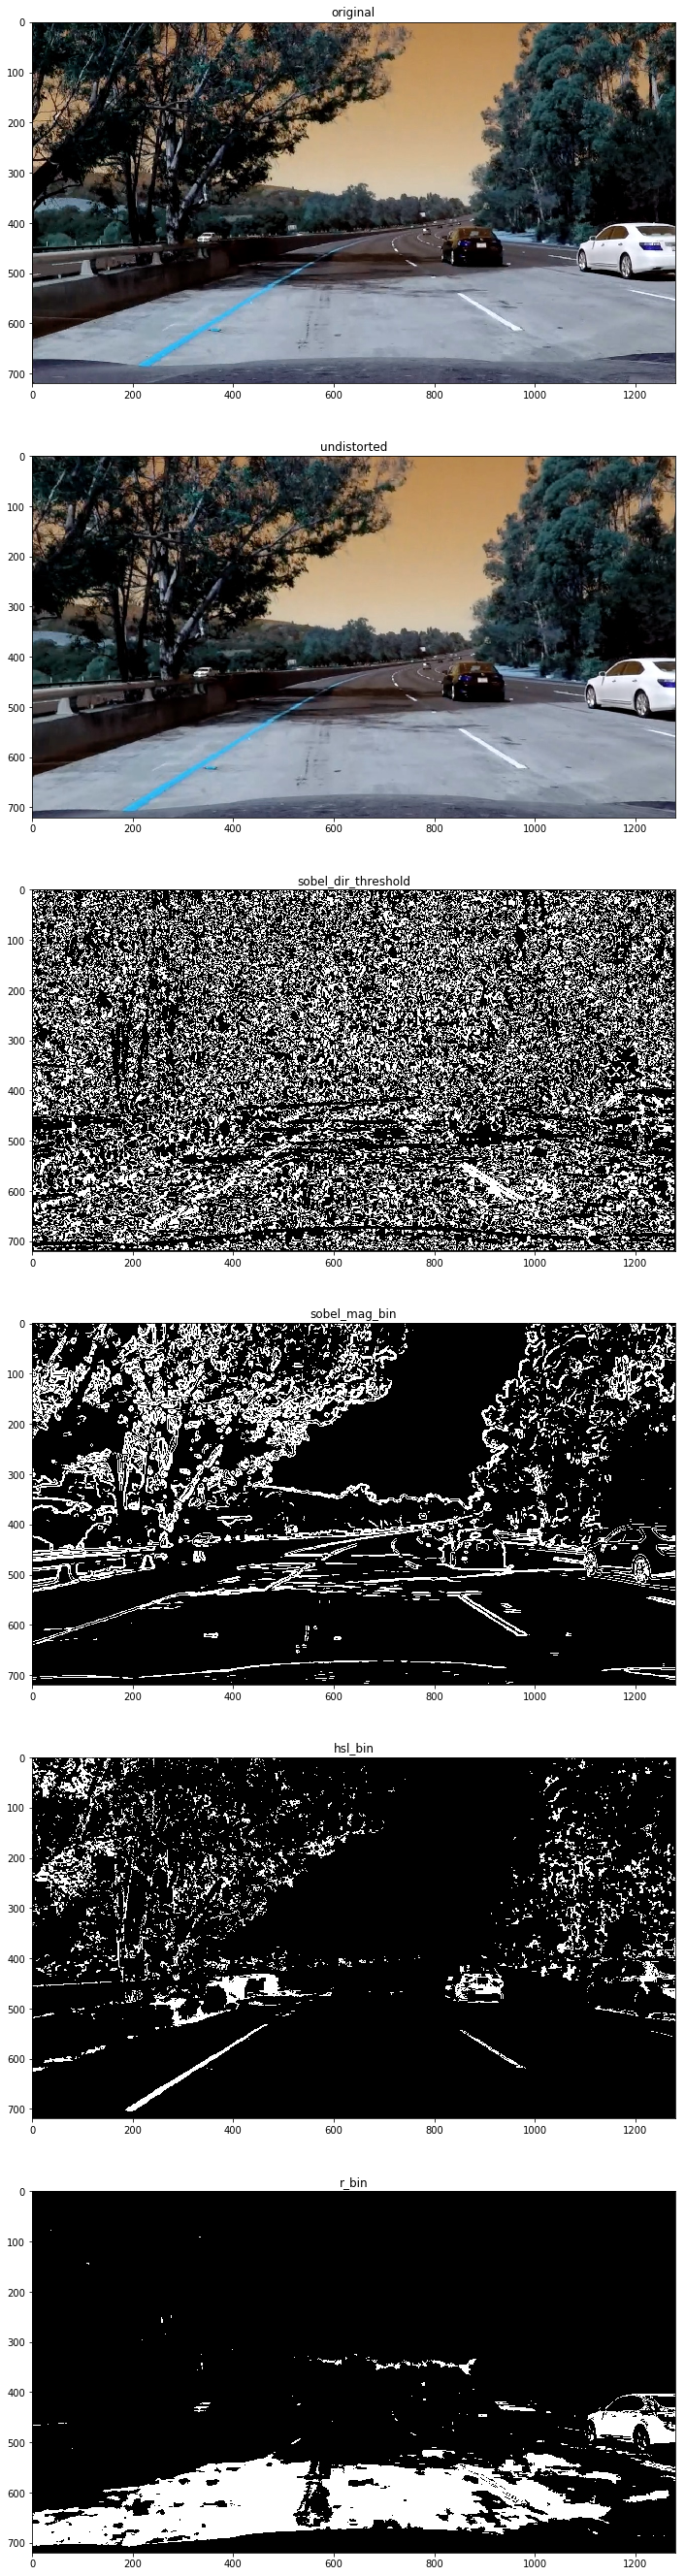

In [57]:
img = images[6]
ret = pipeline(img, kernel_size=3, thresh=(0, 255))

sobel_dir_threshold = dir_threshold(ret['undistorted'], sobel_kernel=15, thresh=(0.7, 1.3))
sobel_mag_bin = mag_thresh(ret['undistorted'], sobel_kernel=11, thresh=(30, 100))
hsl_bin = hls_select(ret['undistorted'], thresh=(170, 255))

# thresh R channel
r_low, r_high = 180, 255
r_ch = ret['undistorted'][:,:,2]
r_out = np.zeros_like(r_ch)
r_out[(r_ch > r_low) & (r_ch < r_high)] = 255

imgs_to_plot = [('original', ret['input']),
                ('undistorted', ret['undistorted']),
                ('sobel_dir_threshold', sobel_dir_threshold),
                ('sobel_mag_bin', sobel_mag_bin),
                ('hsl_bin', hsl_bin),
                ('r_bin', r_out)
               ]

rows, cols = len(imgs_to_plot), 1
fig, subplots = plt.subplots(rows, cols, figsize=(20, 8*rows))
for ax, im_to_plot in zip(subplots, imgs_to_plot):
    title, im = im_to_plot
    ax.imshow(im, cmap='gray')
    ax.set_title(title)

In [101]:
img = images[0]
ret0 = pipeline(img, kernel_size=3, thresh=(0, 255))

window = cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
exit = False
while not exit:
    for key, im in ret0.items():
        im_txt = write_on_image(im, [key])
        cv2.imshow('frame', im_txt)
        key = cv2.waitKey()
        if key == ord('q'):
            exit = True
            break
cv2.destroyAllWindows()

In [80]:
ls *mp4

challenge_video.mp4  harder_challenge_video.mp4  project_video.mp4


In [112]:
fn = 'harder_challenge_video.mp4'
cap = cv2.VideoCapture(fn)
folder_name = fn.rstrip('.mp4')
dst = os.path.join('video_imgs', folder_name)
i = 0
while True:
    ret, im = cap.read()
    if not ret:
        break
    cv2.imwrite(os.path.join(dst, '{}.jpg'.format(i)), im)
    i += 1